<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

# 컴퓨터 비전 핵심 정리

## 차례
1.  **렌즈 왜곡 (Lens Distortion)**
2.  **특징 추출 (Feature Extraction)**
3.  **삼각 측량 (Triangulation)**

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.spatial.transform import Rotation as R
import ipywidgets as widgets
from ipywidgets import interact

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. 렌즈 왜곡 (Lens Distortion)

Real camera lenses don't create perfect perspective projections - they introduce **distortions** that bend straight lines into curves.

### 왜곡의 종류 (Types of Distortion)

1.  **방사형 왜곡 (Radial Distortion)**: Most common, caused by lens shape
    *   **배럴 왜곡 (Barrel Distortion)** (negative $k_1$): Lines curve outward (wide-angle lenses)
    *   **핀쿠션 왜곡 (Pincushion Distortion)** (positive $k_1$): Lines curve inward (telephoto lenses)
    
2.  **접선 왜곡 (Tangential Distortion)**: Caused by lens not being parallel to sensor (less common)

### 방사형 왜곡 모델 (Radial Distortion Model)

Starting from the ideal projected point $(x, y)$ in **normalized image coordinates**.
Here, if a 3D point in camera space is $(X, Y, Z)$, then the normalized coordinates are $x=X/Z$ and $y=Y/Z$.

**Note on Terminology:**
In Computer Graphics (e.g., OpenGL), "Normalized Device Coordinates (NDC)" are strictly defined within $[-1, 1]$.
However, in **Computer Vision**, "normalized image coordinates" simply mean the coordinates on the virtual image plane located at $Z=1$.
*   They are "normalized" by depth $Z$, not by the image size.
*   Therefore, they represent the tangent of the view angle and **can exceed** $[-1, 1]$ if the Field of View (FOV) is large (e.g., $>90^\circ$).

We apply distortion to these normalized coordinates (Note: The focal length $f$ is applied *after* this step to convert to pixel coordinates):
$$
\begin{align}
r^2 &= x^2 + y^2 \\
x_{\text{distorted}} &= x(1 + k_1 r^2 + k_2 r^4) \\
y_{\text{distorted}} &= y(1 + k_1 r^2 + k_2 r^4)
\end{align}
$$

Where:
*   $k_1, k_2$ are radial distortion coefficients
*   $k_1$ dominates the effect (typically -0.5 to 0.3 for real lenses)
*   $k_2$ is the secondary correction (typically -0.1 to 0.1)
*   $r$ is the distance from the image center
*   Higher-order terms ($k_3 r^6$, etc.) exist in theory but are rarely needed in practice

### 왜곡 보정 (Undistortion)

Structure from Motion (SfM) tools like COLMAP estimate distortion coefficients along with camera intrinsics.

**Pipeline Order:**
1.  **Feature Extraction & Matching**: Performed on **original (distorted)** images because distortion parameters are initially unknown.
2.  **Sparse Reconstruction (SfM)**: Estimates camera poses and **distortion parameters** using the matched features.
3.  **Undistortion**: Images are undistorted using the estimated parameters.
4.  **Dense Reconstruction / Gaussian Splatting**: Performed on the **undistorted** images to ensure straight lines remain straight and epipolar geometry holds.

**왜곡 보정 문제 (The Undistortion Problem):**

Given distorted pixel coordinates $(x_{\text{dist}}, y_{\text{dist}})$ from the camera, we want to find the original undistorted coordinates $(x, y)$.

We know:
$$
x_{\text{dist}} = x(1 + k_1 r^2 + k_2 r^4)
$$

But we **cannot** simply solve for $x$ algebraically because $r^2 = x^2 + y^2$ appears in the equation - it's a nonlinear equation!

**반복적 해법 (Iterative Solution):**

We use **[fixed-point iteration](https://en.wikipedia.org/wiki/Fixed-point_iteration)** to solve this:

1. Start with initial guess: $x^{(0)} = x_{\text{dist}}$, $y^{(0)} = y_{\text{dist}}$
2. For each iteration $i$:
   - Compute $r^2 = (x^{(i)})^2 + (y^{(i)})^2$
   - Compute distortion factor: $d = 1 + k_1 r^2 + k_2 r^4$
   - Update: $x^{(i+1)} = x_{\text{dist}} / d$, $y^{(i+1)} = y_{\text{dist}} / d$
3. Repeat until convergence (typically 5-10 iterations)

**실제 적용 (In Practice):**

*   OpenCV's `cv2.undistort()` uses this iterative approach
*   COLMAP undistorts images after calibration for better feature matching
*   Gaussian Splatting works better with undistorted images (straight lines stay straight)
*   Our demo below shows this process visually - adjust the iterations slider to see convergence

**캘리브레이션 참고 (Calibration Note):**

In Structure from Motion and Gaussian Splatting pipelines, $k_1$ and $k_2$ are **unknown variables** that must be estimated along with camera intrinsics (focal length, principal point) and extrinsics (rotation, translation). COLMAP solves this by jointly optimizing all parameters through bundle adjustment - minimizing reprojection error across all images. Once estimated, these distortion coefficients are used to undistort images before 3D reconstruction.

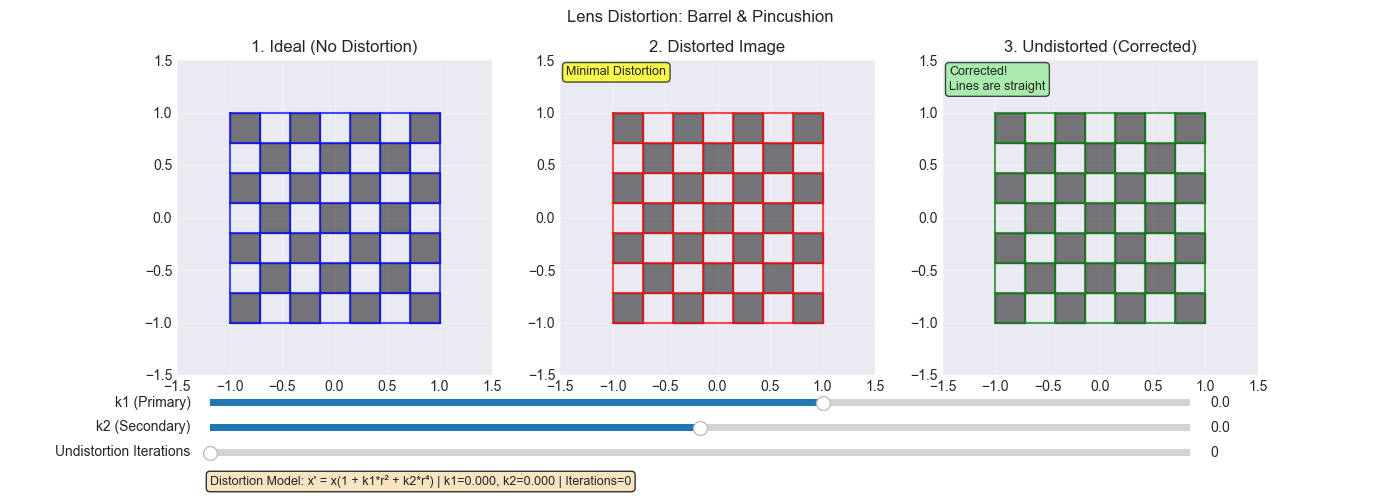

In [ ]:
# Interactive Lens Distortion Demo
fig = plt.figure(figsize=(14, 5))
fig.suptitle("Lens Distortion: Barrel & Pincushion")
plt.subplots_adjust(bottom=0.25)

# Create a checkerboard grid
grid_size = 8
x_grid = np.linspace(-1, 1, grid_size)
y_grid = np.linspace(-1, 1, grid_size)

# Initial distortion coefficients
k1 = 0.0
k2 = 0.0
iterations = 0

# Subplot 1: Original (Ideal Projection)
ax1 = fig.add_subplot(131)
ax1.set_title("1. Ideal (No Distortion)")
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Subplot 2: Distorted Image
ax2 = fig.add_subplot(132)
ax2.set_title("2. Distorted Image")
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Subplot 3: Undistorted (Corrected)
ax3 = fig.add_subplot(133)
ax3.set_title("3. Undistorted (Corrected)")
ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

# Create sliders with physically plausible ranges
# k1: -0.5 (wide-angle barrel) to +0.3 (telephoto pincushion)
# k2: -0.1 to +0.1 (secondary distortion, typically small)
slider_k1 = Slider(plt.axes([0.15, 0.18, 0.7, 0.03]), "k1 (Primary)", -0.5, 0.3, valinit=k1)
slider_k2 = Slider(plt.axes([0.15, 0.13, 0.7, 0.03]), "k2 (Secondary)", -0.1, 0.1, valinit=k2)
slider_iter = Slider(plt.axes([0.15, 0.08, 0.7, 0.03]), "Undistortion Iterations", 0, 20, valinit=iterations, valstep=1)

info_text = fig.text(0.15, 0.03, '', fontsize=9,
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

def apply_distortion(x, y, k1, k2):
    """Apply radial distortion to normalized coordinates"""
    r2 = x**2 + y**2
    distortion_factor = 1 + k1 * r2 + k2 * r2**2
    x_dist = x * distortion_factor
    y_dist = y * distortion_factor
    return x_dist, y_dist

def apply_undistortion(x_dist, y_dist, k1, k2, iterations=5):
    """Iteratively undistort coordinates"""
    x = x_dist.copy()
    y = y_dist.copy()
    
    for _ in range(iterations):
        x = TODO
        y = TODO
    return x, y

def update(val):
    k1 = slider_k1.val
    k2 = slider_k2.val
    iterations = int(slider_iter.val)
    
    # --- Subplot 1: Original Grid ---
    ax1.clear()
    ax1.set_title("1. Ideal (No Distortion)")
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # Draw checkerboard
    for i in range(grid_size - 1):
        for j in range(grid_size - 1):
            if (i + j) % 2 == 0:
                x_corner = [x_grid[i], x_grid[i+1], x_grid[i+1], x_grid[i]]
                y_corner = [y_grid[j], y_grid[j], y_grid[j+1], y_grid[j+1]]
                ax1.fill(x_corner, y_corner, color='black', alpha=0.5)
    
    # Draw grid lines (horizontal and vertical)
    for i in range(grid_size):
        ax1.plot(x_grid, [y_grid[i]] * grid_size, 'b-', linewidth=1.5, alpha=0.7)
        ax1.plot([x_grid[i]] * grid_size, y_grid, 'b-', linewidth=1.5, alpha=0.7)
    
    # --- Subplot 2: Distorted Grid ---
    ax2.clear()
    ax2.set_title("2. Distorted Image")
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    # Apply distortion to checkerboard
    for i in range(grid_size - 1):
        for j in range(grid_size - 1):
            if (i + j) % 2 == 0:
                x_corner = np.array([x_grid[i], x_grid[i+1], x_grid[i+1], x_grid[i]])
                y_corner = np.array([y_grid[j], y_grid[j], y_grid[j+1], y_grid[j+1]])
                
                x_dist, y_dist = apply_distortion(x_corner, y_corner, k1, k2)
                ax2.fill(x_dist, y_dist, color='black', alpha=0.5)
    
    # Draw distorted grid lines
    for i in range(grid_size):
        # Horizontal lines
        x_line = x_grid
        y_line = np.full_like(x_grid, y_grid[i])
        x_dist, y_dist = apply_distortion(x_line, y_line, k1, k2)
        ax2.plot(x_dist, y_dist, 'r-', linewidth=1.5, alpha=0.7)
        
        # Vertical lines
        x_line = np.full_like(y_grid, x_grid[i])
        y_line = y_grid
        x_dist, y_dist = apply_distortion(x_line, y_line, k1, k2)
        ax2.plot(x_dist, y_dist, 'r-', linewidth=1.5, alpha=0.7)
    
    # Label distortion type
    if k1 < -0.1:
        distortion_type = "Barrel Distortion\n(Wide-angle lens)"
    elif k1 > 0.1:
        distortion_type = "Pincushion Distortion\n(Telephoto lens)"
    else:
        distortion_type = "Minimal Distortion"
    
    ax2.text(0.02, 0.98, distortion_type, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # --- Subplot 3: Undistorted Grid ---
    ax3.clear()
    ax3.set_title("3. Undistorted (Corrected)")
    ax3.set_xlim(-1.5, 1.5)
    ax3.set_ylim(-1.5, 1.5)
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    
    # First distort, then undistort to show correction
    for i in range(grid_size - 1):
        for j in range(grid_size - 1):
            if (i + j) % 2 == 0:
                x_corner = np.array([x_grid[i], x_grid[i+1], x_grid[i+1], x_grid[i]])
                y_corner = np.array([y_grid[j], y_grid[j], y_grid[j+1], y_grid[j+1]])
                
                # Distort then undistort
                x_dist, y_dist = apply_distortion(x_corner, y_corner, k1, k2)
                x_undist, y_undist = apply_undistortion(x_dist, y_dist, k1, k2, iterations)
                ax3.fill(x_undist, y_undist, color='black', alpha=0.5)
    
    # Draw undistorted grid lines
    for i in range(grid_size):
        # Horizontal lines
        x_line = x_grid
        y_line = np.full_like(x_grid, y_grid[i])
        x_dist, y_dist = apply_distortion(x_line, y_line, k1, k2)
        x_undist, y_undist = apply_undistortion(x_dist, y_dist, k1, k2, iterations)
        ax3.plot(x_undist, y_undist, 'g-', linewidth=1.5, alpha=0.7)
        
        # Vertical lines
        x_line = np.full_like(y_grid, x_grid[i])
        y_line = y_grid
        x_dist, y_dist = apply_distortion(x_line, y_line, k1, k2)
        x_undist, y_undist = apply_undistortion(x_dist, y_dist, k1, k2, iterations)
        ax3.plot(x_undist, y_undist, 'g-', linewidth=1.5, alpha=0.7)
    
    ax3.text(0.02, 0.98, "Corrected!\nLines are straight", transform=ax3.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # Update info text
    info_text.set_text(f"Distortion Model: x' = x(1 + k1*r² + k2*r⁴) | k1={k1:.3f}, k2={k2:.3f} | Iterations={iterations}")
    
    fig.canvas.draw_idle()

slider_k1.on_changed(update)
slider_k2.on_changed(update)
slider_iter.on_changed(update)

# Initial draw
update(None)

plt.show()

## 2. 특징 추출 (Feature Extraction)

Before we can triangulate 3D points, we need to find **corresponding points** across multiple images. Feature extraction is the first step in Structure from Motion (SfM) pipelines like COLMAP.

### 핵심 개념 (Key Concepts)

1.  **키포인트 검출 (Keypoint Detection)**: Find distinctive points in images (corners, blobs, edges)
2.  **특징 기술 (Feature Description)**: Create a unique descriptor for each keypoint (robust to rotation, scale, illumination)
3.  **특징 매칭 (Feature Matching)**: Match keypoints across images based on descriptor similarity

### 일반적인 특징 검출기 (Common Feature Detectors)

*   **SIFT** (Scale-Invariant Feature Transform): Gold standard, patent-free since 2020
*   **ORB** (Oriented FAST and Rotated BRIEF): Fast, free alternative
*   **SuperPoint**: Deep learning-based detector (used in modern SfM)

### 시각화 (Visualization)

Below we show SIFT features detected in two consecutive frames. These keypoints will be matched across images, then triangulated to recover 3D structure.

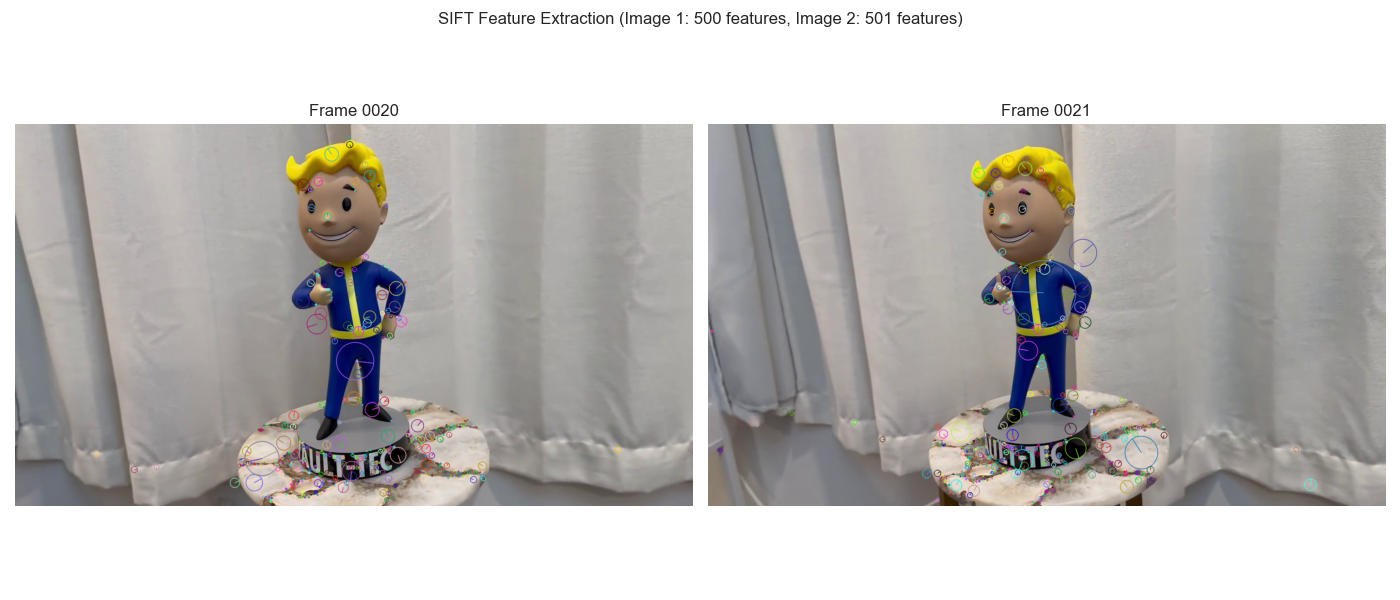

Detected 500 keypoints in image 1
Detected 501 keypoints in image 2

These features are used in SfM pipelines like COLMAP to:
1. Match corresponding points across images
2. Estimate camera poses (rotation & translation)
3. Triangulate 3D points
4. Refine with bundle adjustment


In [3]:
import cv2
import os

# Try to load images
img1_path = '0020.png'
img2_path = '0021.png'

if os.path.exists(img1_path) and os.path.exists(img2_path):
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Create SIFT detector
    sift = cv2.SIFT_create(nfeatures=500)
    
    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)
    
    # Draw keypoints
    img1_kp = cv2.drawKeypoints(img1_rgb, kp1, None, 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kp = cv2.drawKeypoints(img2_rgb, kp2, None,
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"SIFT Feature Extraction (Image 1: {len(kp1)} features, Image 2: {len(kp2)} features)")
    
    axes[0].imshow(img1_kp)
    axes[0].set_title("Frame 0020")
    axes[0].axis('off')
    
    axes[1].imshow(img2_kp)
    axes[1].set_title("Frame 0021")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detected {len(kp1)} keypoints in image 1")
    print(f"Detected {len(kp2)} keypoints in image 2")
    print("\nThese features are used in SfM pipelines like COLMAP to:")
    print("1. Match corresponding points across images")
    print("2. Estimate camera poses (rotation & translation)")
    print("3. Triangulate 3D points")
    print("4. Refine with bundle adjustment")
else:
    print(f"Images not found: {img1_path} or {img2_path}")
    print("Please ensure these files are in the same directory as this notebook.")

### 특징 매칭 (Feature Matching)

After detecting keypoints and computing descriptors, the next step is **matching** - finding corresponding features between images. This is crucial for:

*   **Camera pose estimation**: RANSAC with Essential/Fundamental matrix
*   **3D reconstruction**: Triangulating matched points
*   **Image stitching**: Panorama creation

**매칭 전략 (Matching Strategy):**

1.  **Brute-Force Matching**: Compare each descriptor in image 1 with all descriptors in image 2
2.  **Distance Metric**: For SIFT, use L2 (Euclidean) distance between 128-dimensional descriptors
3.  **Lowe's Ratio Test**: Accept match only if nearest neighbor is significantly closer than second-nearest (ratio < 0.7-0.8)
    *   This filters out ambiguous matches where multiple keypoints are similar
    *   Ratio = $\frac{d_1}{d_2}$ where $d_1$ is distance to nearest, $d_2$ to second-nearest

**왜 비율 테스트인가? (Why Ratio Test?)**

Without it, we get many **false positives** (incorrect matches). The ratio test keeps only distinctive matches where the best match is clearly better than alternatives.


Feature Matching Results:
Total possible matches: 500
Good matches (after ratio test): 193
Match ratio: 38.6%


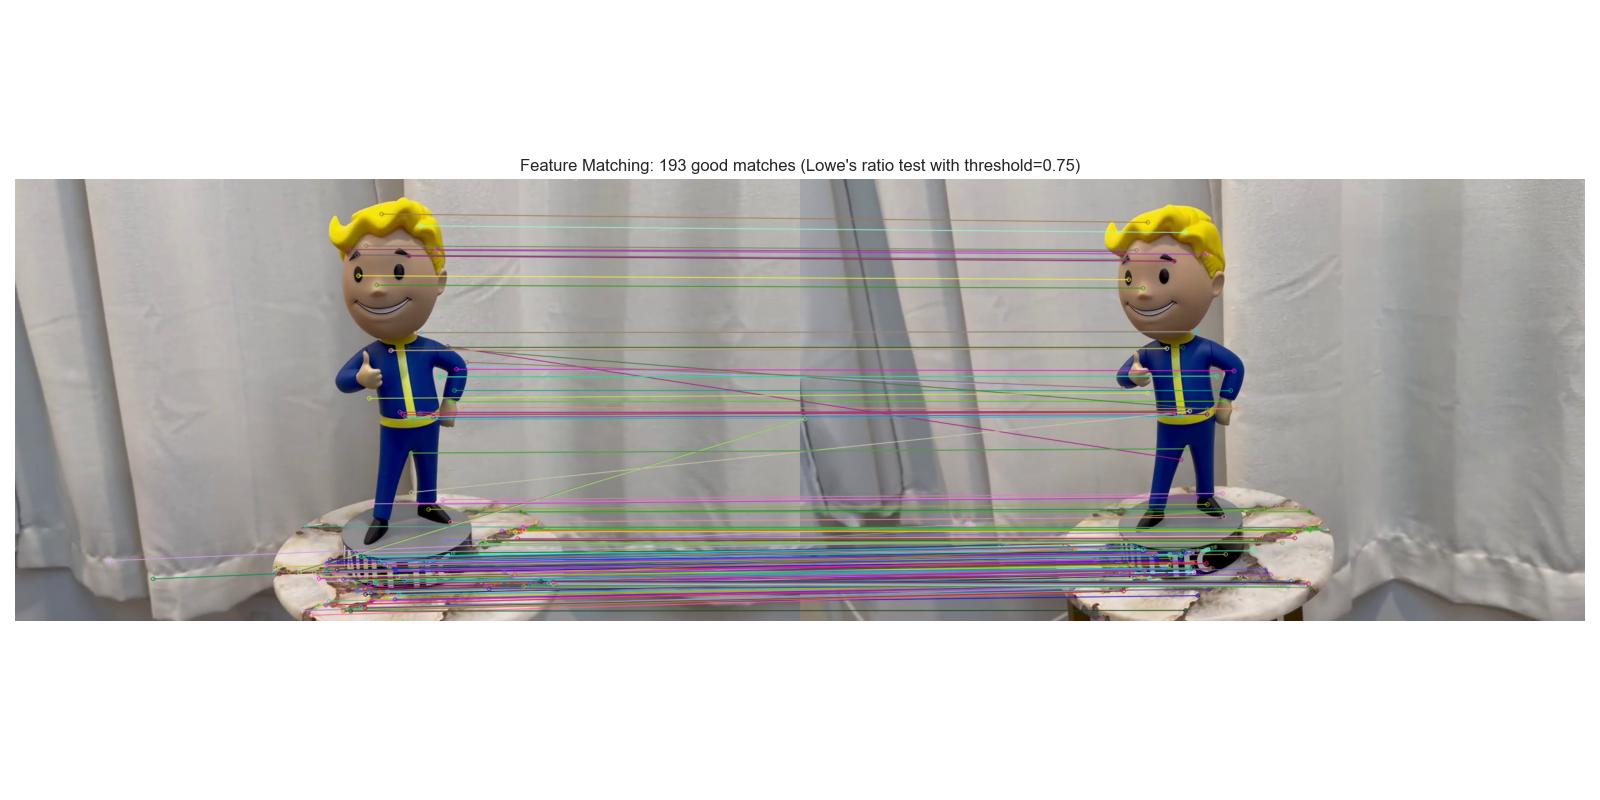


Match Quality Statistics:
Mean descriptor distance: 154.65
Std descriptor distance: 50.69
Min distance: 40.62
Max distance: 287.37

Next Steps in SfM Pipeline:
1. Use these matches to estimate Essential Matrix (camera motion)
2. Apply RANSAC to filter outliers
3. Recover rotation & translation from Essential Matrix
4. Triangulate 3D points from inlier matches


In [4]:
# Feature Matching Demo
if os.path.exists(img1_path) and os.path.exists(img2_path):
    # We already have kp1, des1, kp2, des2 from previous cell
    
    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    
    # Match descriptors using kNN (k=2 to get 2 nearest neighbors)
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:  # Ensure we have 2 neighbors
            m, n = match_pair
            if m.distance < 0.75 * n.distance:  # Ratio threshold = 0.75
                good_matches.append(m)
    
    print(f"\nFeature Matching Results:")
    print(f"Total possible matches: {len(matches)}")
    print(f"Good matches (after ratio test): {len(good_matches)}")
    print(f"Match ratio: {len(good_matches)/len(matches)*100:.1f}%")
    
    # Draw matches
    img_matches = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, good_matches, None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display
    fig = plt.figure(figsize=(16, 8))
    plt.imshow(img_matches)
    plt.title(f"Feature Matching: {len(good_matches)} good matches (Lowe's ratio test with threshold=0.75)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Analyze match quality
    distances = [m.distance for m in good_matches]
    if distances:
        print(f"\nMatch Quality Statistics:")
        print(f"Mean descriptor distance: {np.mean(distances):.2f}")
        print(f"Std descriptor distance: {np.std(distances):.2f}")
        print(f"Min distance: {np.min(distances):.2f}")
        print(f"Max distance: {np.max(distances):.2f}")
        
        print("\nNext Steps in SfM Pipeline:")
        print("1. Use these matches to estimate Essential Matrix (camera motion)")
        print("2. Apply RANSAC to filter outliers")
        print("3. Recover rotation & translation from Essential Matrix")
        print("4. Triangulate 3D points from inlier matches")
else:
    print("Images not loaded. Please run the previous cell first.")

## 3. 삼각 측량 (Triangulation)

Once we have matches between images and the camera poses, how do we get the 3D point?
We cast rays from each camera center through the pixel. The intersection of these rays is the 3D point.
In practice, rays never perfectly intersect due to noise, so we find the point closest to both rays.

### 삼각 측량의 수학적 원리 (Math Behind Triangulation)

**좌표계 참고 (Note on Coordinates):** All points and vectors here are in **standard 3D Cartesian coordinates** (not homogeneous coordinates). Camera centers $\mathbf{c}_1, \mathbf{c}_2$ and directions $\mathbf{d}_1, \mathbf{d}_2$ are 3-vectors like $(x, y, z)$. Homogeneous coordinates (4-vectors) are useful for projective transformations, but for triangulation we work directly in 3D Euclidean space.

Given two cameras with centers $\mathbf{c}_1$ and $\mathbf{c}_2$, and two ray directions $\mathbf{d}_1$ and $\mathbf{d}_2$ (unit vectors), we can represent the rays as:

$$
\begin{align}
\text{Ray 1: } & \mathbf{p}_1(t) = \mathbf{c}_1 + t \cdot \mathbf{d}_1 \\
\text{Ray 2: } & \mathbf{p}_2(u) = \mathbf{c}_2 + u \cdot \mathbf{d}_2
\end{align}
$$

where $t$ and $u$ are scalar parameters along each ray.

**목표 (Goal):** Find the closest points $\mathbf{p}_1(t^*)$ and $\mathbf{p}_2(u^*)$ on these two lines.

We want to minimize the **squared distance** (loss function) between points on the two rays. Let $\mathbf{w}_0 = \mathbf{c}_1 - \mathbf{c}_2$:

$$
\begin{align}
L(t, u) &= \|\mathbf{p}_1(t) - \mathbf{p}_2(u)\|^2 \\
&= \|(\mathbf{c}_1 + t\mathbf{d}_1) - (\mathbf{c}_2 + u\mathbf{d}_2)\|^2 \\
&= \|\mathbf{w}_0 + t\mathbf{d}_1 - u\mathbf{d}_2\|^2
\end{align}
$$

Expanding the squared norm using the dot product $\|\mathbf{v}\|^2 = \mathbf{v} \cdot \mathbf{v}$:

$$
\begin{align}
L(t, u) &= (\mathbf{w}_0 + t\mathbf{d}_1 - u\mathbf{d}_2) \cdot (\mathbf{w}_0 + t\mathbf{d}_1 - u\mathbf{d}_2) \\
&= \mathbf{w}_0 \cdot \mathbf{w}_0 + 2t(\mathbf{w}_0 \cdot \mathbf{d}_1) - 2u(\mathbf{w}_0 \cdot \mathbf{d}_2) \\
&\quad + t^2(\mathbf{d}_1 \cdot \mathbf{d}_1) + u^2(\mathbf{d}_2 \cdot \mathbf{d}_2) - 2tu(\mathbf{d}_1 \cdot \mathbf{d}_2)
\end{align}
$$

To minimize, we take partial derivatives and set them to zero:

$$
\begin{align}
\frac{\partial L}{\partial t} &= 2(\mathbf{w}_0 \cdot \mathbf{d}_1) + 2t(\mathbf{d}_1 \cdot \mathbf{d}_1) - 2u(\mathbf{d}_1 \cdot \mathbf{d}_2) = 0 \\
\frac{\partial L}{\partial u} &= -2(\mathbf{w}_0 \cdot \mathbf{d}_2) + 2u(\mathbf{d}_2 \cdot \mathbf{d}_2) - 2t(\mathbf{d}_1 \cdot \mathbf{d}_2) = 0
\end{align}
$$

Dividing by 2 and rearranging:

$$
\begin{align}
t(\mathbf{d}_1 \cdot \mathbf{d}_1) - u(\mathbf{d}_1 \cdot \mathbf{d}_2) &= -\mathbf{w}_0 \cdot \mathbf{d}_1 \\
-t(\mathbf{d}_1 \cdot \mathbf{d}_2) + u(\mathbf{d}_2 \cdot \mathbf{d}_2) &= \mathbf{w}_0 \cdot \mathbf{d}_2
\end{align}
$$

This is a 2×2 linear system. Let's introduce notation: $a = \mathbf{d}_1 \cdot \mathbf{d}_1 = 1$, $b = \mathbf{d}_1 \cdot \mathbf{d}_2$, $c = \mathbf{d}_2 \cdot \mathbf{d}_2 = 1$, $d = \mathbf{d}_1 \cdot \mathbf{w}_0$, $e = \mathbf{d}_2 \cdot \mathbf{w}_0$.

The system becomes:
$$
\begin{bmatrix}
a & -b \\
-b & c
\end{bmatrix}
\begin{bmatrix}
t \\ u
\end{bmatrix}
=
\begin{bmatrix}
-d \\
e
\end{bmatrix}
$$

The solution is:
$$
t^* = \frac{be - cd}{ac - b^2}, \quad u^* = \frac{ae - bd}{ac - b^2}
$$

The **triangulated 3D point** is the midpoint:
$$
\mathbf{P} = \frac{\mathbf{p}_1(t^*) + \mathbf{p}_2(u^*)}{2}
$$

The distance $\|\mathbf{p}_1(t^*) - \mathbf{p}_2(u^*)\|$ indicates the triangulation error (zero for perfect intersection).

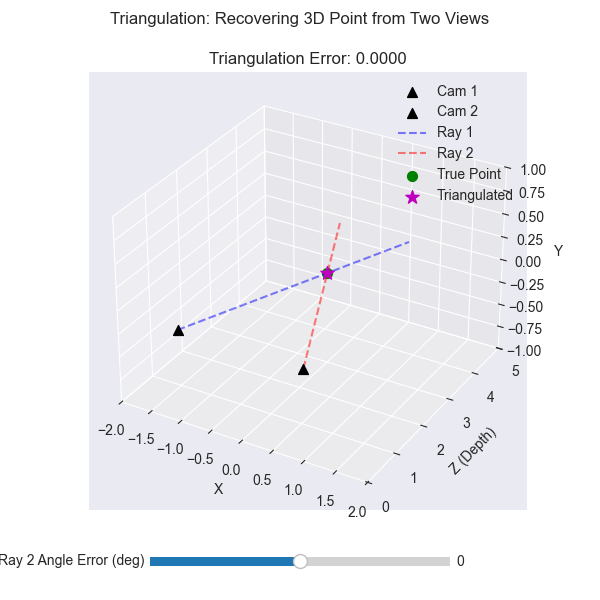

In [ ]:
%matplotlib widget

from scipy.spatial.transform import Rotation as R

# Initialize figure and parameter
angle_deg = 0.0

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Triangulation: Recovering 3D Point from Two Views")

# Create subplot
ax = fig.add_subplot(111, projection='3d')

# Adjust layout for slider
plt.subplots_adjust(bottom=0.15)

# Create slider
slider_angle = Slider(plt.axes([0.25, 0.05, 0.5, 0.03]), "Ray 2 Angle Error (deg)", -10, 10, valinit=angle_deg)

def update(val):
    angle_deg = slider_angle.val
    
    # Two cameras
    c1 = np.array([-1, 0, 0])
    c2 = np.array([1, 0, 0])
    P = np.array([0, 0, 3])
    
    # Ray directions
    d1 = P - c1
    d1 = d1 / np.linalg.norm(d1)
    
    d2_ideal = P - c2
    d2_ideal = d2_ideal / np.linalg.norm(d2_ideal)
    
    r = R.from_euler('y', angle_deg, degrees=True)
    d2 = r.apply(d2_ideal)
    
    # Find intersection
    w0 = c1 - c2
    a = np.dot(TODO)
    b = np.dot(TODO)
    c = np.dot(TODO)
    d = np.dot(TODO)
    e = np.dot(TODO)
    
    denom = a*c - b*b
    if denom < 1e-5:
        t = 0
        u = 0
    else:
        t = TODO
        u = TODO
    
    P1 = c1 + t * d1
    P2 = c2 + u * d2
    P_est = (P1 + P2) / 2.0
    
    dist = np.linalg.norm(P1 - P2)
    
    # Update plot
    ax.clear()
    
    # Cameras
    ax.scatter(c1[0], c1[2], c1[1], c='k', s=50, marker='^', label='Cam 1')
    ax.scatter(c2[0], c2[2], c2[1], c='k', s=50, marker='^', label='Cam 2')
    
    # Rays
    l = 5.0
    ax.plot([c1[0], c1[0]+d1[0]*l], [c1[2], c1[2]+d1[2]*l], [c1[1], c1[1]+d1[1]*l], 'b--', alpha=0.5, label='Ray 1')
    ax.plot([c2[0], c2[0]+d2[0]*l], [c2[2], c2[2]+d2[2]*l], [c2[1], c2[1]+d2[1]*l], 'r--', alpha=0.5, label='Ray 2')
    
    # Points
    ax.scatter(P[0], P[2], P[1], c='g', s=50, label='True Point')
    ax.scatter(P_est[0], P_est[2], P_est[1], c='m', s=100, marker='*', label='Triangulated')
    
    # Connection line (error)
    if dist > 0.1:
        ax.plot([P1[0], P2[0]], [P1[2], P2[2]], [P1[1], P2[1]], 'k-', linewidth=1)
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 5)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y')
    ax.set_title(f"Triangulation Error: {dist:.4f}")
    ax.legend()
    
    fig.canvas.draw_idle()

# Connect slider
slider_angle.on_changed(update)

# Initial update
update(None)

plt.show()


## 더 알아보기

[Making Your Own Room With a View | National Geographic](https://www.youtube.com/watch?v=gvzpu0Q9RTU)

[Computer Vision II: Multiple View Geometry](https://cvg.cit.tum.de/teaching/online/mvg)

[3D Computer Vision | National University of Singapore](https://www.youtube.com/playlist?list=PLxg0CGqViygP47ERvqHw_v7FVnUovJeaz)

[다중관점기하학 개념 정리 - 한국어](https://www.youtube.com/watch?v=ZO91k-zAyMk&list=PLddVNIYmpwlPY6KElbvmfKpcwwVWeggmv)

[컴퓨터비전 특강 - 한국어](https://youtu.be/N6vP0T1Xabg?si=j5Bbx_2YdmYJ5ZwZ)

[고려대학교 Introduction to Computer Vision](https://www.youtube.com/playlist?list=PLW_xDnYtBZJn7cRa7SthQQsXM9s77xrh2)
